## Prep

In [28]:
# Import packages
import pandas as pd
import plotly.graph_objects as go
import networkx as nx
from ds_common_utils.aux.io.snowflake_tools import SnowflakeTools
from math import log
from networkx.algorithms.community import greedy_modularity_communities
import matplotlib.pyplot as plt
import community.community_louvain as community_louvain
import numpy as np

In [29]:
# Get connection
con = SnowflakeTools().get_snowflake_ctx(
     method = 'token',
    user = '250807',
    role = 'INSIGHT_ANALYST_MERCH_DE_GENERAL_PRD',
    warehouse = 'INSIGHT_ANALYST_WH'
)
with open('sql/item_association.sql', 'r') as query:
        df = pd.read_sql_query(query.read(), con)
with open('sql/excluded_class_list.sql', 'r') as query:
        target_item_class = pd.read_sql_query(query.read(), con)

snowflake_tools - 2025-06-20 16:09:11.598064+10:00 - Generating new token with 'INSIGHT_ANALYST_MERCH_DE_GENERAL_PRD' role and 'SESSION:ROLE-ANY' scope...
snowflake_tools - 2025-06-20 16:09:17.077545+10:00 - Saved token with '2025-06-20 20:09:17+10:00' expiry...


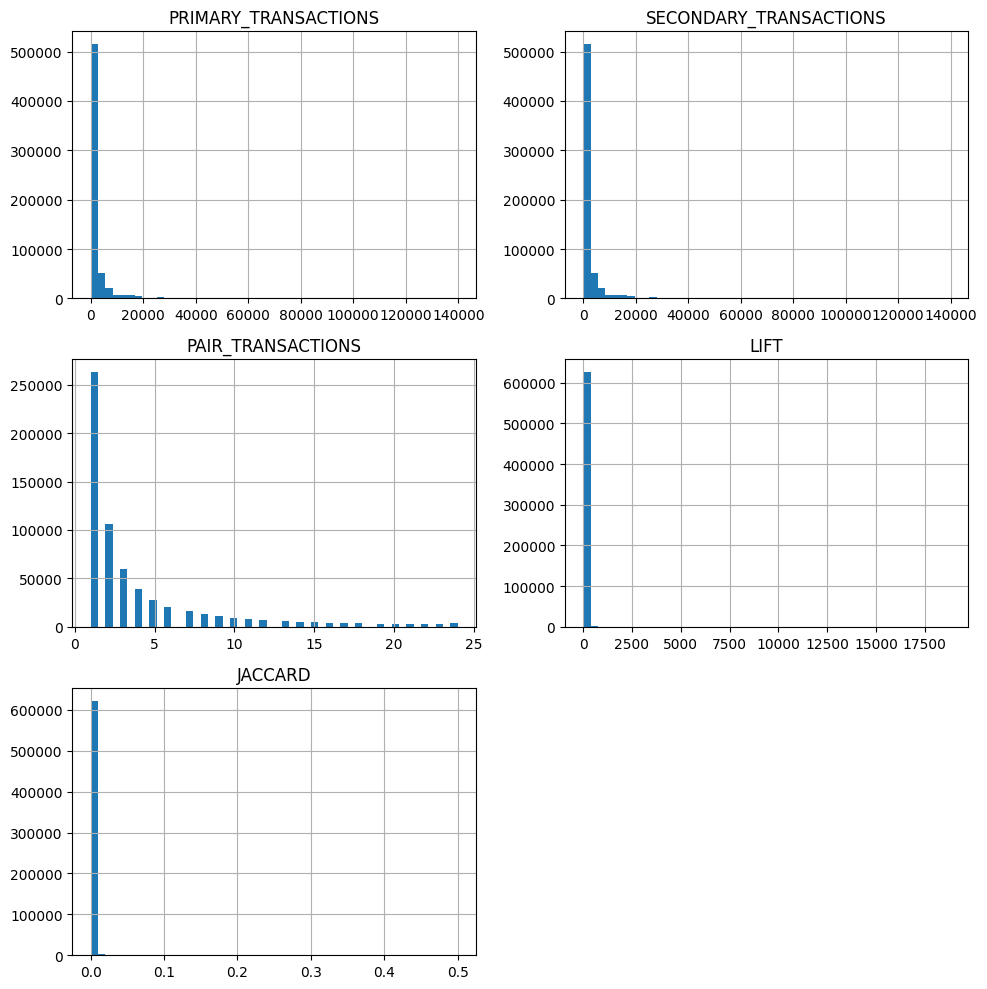

In [36]:
# Plot histograms of numerical columns
numeric_cols = df.select_dtypes(include='number').columns
df[numeric_cols].hist(bins=50, figsize=(10, 10), layout=(3, 2))
plt.tight_layout()
plt.show()

## Parameter Tuning

In [43]:
TRX_THRESHOLD = 10 # Min N frequent pairs
QUANTILE = 0.975 # Nth percentile of metric similarity
TOP_N = 3 # top-N associated item classes per primary class
RESO = 1 # >1.0 → more, smaller communities
METRIC = 'LIFT' # LIFT or JACCARD

## Working

In [44]:
# filtered_df = df

filtered_df = df[
    df['PRIMARY_ID'].isin(target_item_class['ITEM_CLASS_NAME']) &
    ~df['SECONDARY_ID'].isin(target_item_class['ITEM_CLASS_NAME'])
]

filtered_df = filtered_df[filtered_df['PAIR_TRANSACTIONS'] >= TRX_THRESHOLD]
threshold = filtered_df[METRIC].quantile(QUANTILE)
filtered_df = filtered_df[filtered_df[METRIC] >= threshold]
top_edges = filtered_df.sort_values(METRIC, ascending=False).groupby('PRIMARY_ID').head(TOP_N)


In [45]:
filtered_df.sort_values(by='PAIR_TRANSACTIONS', ascending=False)

,PRIMARY_ID,SECONDARY_ID,PRIMARY_TRANSACTIONS,SECONDARY_TRANSACTIONS,TRX_START_MONTH,TRX_END_MONTH,PAIR_TRANSACTIONS,LIFT,JACCARD
302034,500 TERMITE CONTROL,501 PREP AND MAINTENANCE,7393,1052,2024-07-01,2025-06-01,24,1.501815,0.002850
301492,500 TERMITE CONTROL,500 INTERIOR STAINS,7393,462,2024-07-01,2025-06-01,21,2.992253,0.002681
50532,500 CITRONELLA CANDLE,502 LANTERNS,15957,465,2024-07-01,2025-06-01,21,1.377390,0.001280
51499,500 CITRONELLA FLARE,501 RUBS AND SAUCES,6023,875,2024-07-01,2025-06-01,21,1.939278,0.003054
302004,500 TERMITE CONTROL,501 ORBITAL SAND PAPER,7393,879,2024-07-01,2025-06-01,20,1.497829,0.002424
...,...,...,...,...,...,...,...,...,...
51454,500 CITRONELLA FLARE,501 OUTDOOR ELECTRIC HEATERS,6023,100,2024-08-01,2025-06-01,10,8.080325,0.001636
51457,500 CITRONELLA FLARE,501 OUTDOOR PLAY ACC,6023,481,2024-10-01,2025-03-01,10,1.679901,0.001540
51527,500 CITRONELLA FLARE,501 SOLID FUEL HEATERS,6023,48,2024-07-01,2025-05-01,10,16.834011,0.001650
72454,500 CRAWLING PEST SPRAY,501 SITE MANAGEMENT,53342,67,2024-09-01,2025-04-01,10,1.361751,0.000187


In [46]:
mode='lines',
line_shape='spline'
    
# Build node size map from your DataFrame
node_size_map = dict(zip(top_edges['PRIMARY_ID'], top_edges['PRIMARY_TRANSACTIONS']))

# Convert values to NumPy array
sizes = np.array(list(node_size_map.values()))

# Use np.ptp instead of .ptp()
norm_sizes = (sizes - sizes.min()) / np.ptp(sizes)  # scale to 0–1
scaled_sizes = 10 + norm_sizes * 30                 # scale to 10–40

# Final size map: Product ID → Scaled Size
scaled_size_map = dict(zip(node_size_map.keys(), scaled_sizes))

# Step 1: Build the full graph
G = nx.Graph()
for _, row in top_edges.iterrows():
    G.add_edge(row['PRIMARY_ID'], row['SECONDARY_ID'], weight=row[METRIC])

# Step 2: Louvain community detection
partition = community_louvain.best_partition(G, weight=METRIC, resolution=RESO)

# Step 3: Layout
pos = nx.spring_layout(G, weight='weight', seed=42
                      )

# Step 4: Edge trace (no filter on weight)
edge_x, edge_y = [], []
for u, v in G.edges():
    x0, y0 = pos[u]
    x1, y1 = pos[v]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]

edge_trace = go.Scatter(
    x=edge_x,
    y=edge_y,
    line=dict(width=1, color='gray'),
    hoverinfo='none',
    mode='lines'
)

# Step 5: Node trace with Louvain cluster coloring
color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']  # Extend if you expect >10 clusters

node_x, node_y, node_color, node_size, hover_text = [], [], [], [], []

for node in G.nodes():
    x, y = pos[node]
    cluster = partition[node]
    size = scaled_size_map.get(node, 10)  # default to small if missing

    node_x.append(x)
    node_y.append(y)
    node_color.append(color_list[cluster % len(color_list)])
    node_size.append(size)
    hover_text.append(f"Product ID: {node}<br>Cluster: {cluster}<br>Transactions: {int(size)}")

node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode='markers+text',
    hoverinfo='text',
    text=[str(node) for node in G.nodes()],
    textposition='top center',
    marker=dict(
        color=node_color,
        size=node_size,  # <--- size now dynamic!
        line=dict(width=2, color='black')
    ),
    textfont=dict(
    size=16,          # increase for visibility
    color='black',
    family='Arial'
)
)
# Step 6: Plot
fig = go.Figure(
    data=[edge_trace, node_trace],
    layout=go.Layout(
        width=1200,          # increase width
    height=800, 
        title=dict(text='Louvain Product Clustering (All Edges)', x=0.5, font=dict(size=16)),
        showlegend=False,
        hovermode='closest',
        margin=dict(b=20, l=20, r=20, t=40),
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
    )
)

## Results

In [47]:
fig.show()

In [48]:
# Merge community partition info with filtered edges
partition_df = pd.DataFrame.from_dict(partition, orient='index', columns=['segment']).reset_index()
partition_df.rename(columns={'index': 'PRIMARY_ID'}, inplace=True)

# Merge and deduplicate
labelled_df = filtered_df.merge(partition_df, on='PRIMARY_ID', how='left')
labelled_df = labelled_df[['PRIMARY_ID', 'SECONDARY_ID', 'PRIMARY_TRANSACTIONS', 'SECONDARY_TRANSACTIONS', 'PAIR_TRANSACTIONS', METRIC, 'segment']].drop_duplicates()
labelled_df = labelled_df.sort_values(by=['segment', METRIC]).reset_index(drop=True)
labelled_df

,PRIMARY_ID,SECONDARY_ID,PRIMARY_TRANSACTIONS,SECONDARY_TRANSACTIONS,PAIR_TRANSACTIONS,LIFT,segment
0,500 ANT AND SPIDER CONTROL,501 DIGITAL LOCKS,60642,71,12,1.356410,0
1,500 ANT AND SPIDER CONTROL,501 OTHER ANGLE GRINDER ACCESS,60642,59,10,1.360242,0
2,500 ANT AND SPIDER CONTROL,502 FLOOR LAMPS,60642,59,10,1.360242,0
3,500 ANT AND SPIDER CONTROL,500 AC DRYER HANDRAIL,60642,62,11,1.423866,0
4,500 ANT AND SPIDER CONTROL,502 DOOR TRACK SPARE COMP,60642,67,12,1.437390,0
...,...,...,...,...,...,...,...
215,500 MOTH CONTROL,501 LINT ROLLERS,8625,416,10,1.356405,13
216,500 MOTH CONTROL,502 CABINET AND STRIP LIGHTS,8625,358,10,1.576157,13
217,500 RODENT TRAP,501 DOOR LOCK ACCESSORIES,65926,47,10,1.570678,14
218,500 BUG ZAPPER AND TRAPPER,501 BRAZIERS AND FIRE PITS,14809,387,17,1.443623,15
